In [1]:
import mlflow
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import constants as c
torch.cuda.empty_cache()

In [2]:
runs = {
        "florida":
        {
            "CNN": (1, 'e25c6b40324643c3afc1cf42981b11b5'),
            "13x13": (0, 'e1d15a0615ca489aa6a17ec60247d0af'),
            "9x9": (0, '3f48868c52404eb0a833897aa4642871'),
            "5x5": (0, '1824682ae27c48669665cf042052d584'),
            "nf": (0, 'feda42500d2b45549be96f1bf62b0b03')
        },
       "central":
        {
            "CNN": (1, 'fbe44b0423204805bc6af4d7d6ac562e'),
            "13x13": (0, 'bcf7e7cfa8ab4c4196ad6a2bb18e8601'),
            "9x9": (0, '079a94c41ad3482996cc2b9f95adba8d'),
            "5x5": (0, '202ea9f8a73b401fa22e62c24d9ab2d0'),
            "nf": (0, '0c5ee480663f4f9eb7200f8879aa1244')
        },
        "west":
        {
            "CNN": (1, 'f76c0170818244629de4544805f93a59'),
            "13x13": (0, 'c4ec13e65fe74b399fc9e325a9966fef'),
            "9x9": (0, '6abe7a9940c04b47819689070100e5e6'),
            "5x5": (0, '70f5be887eff42e8a216780752644b2f'),
            "nf": (0, 'db9f0fae83c949eaad5d1176a43dae47')
        }
}

region = "florida"

results_florida = {}
i = 999

mu, su = c.region_stats_u10[region]
mv, sv = c.region_stats_v10[region]

dsc = xr.open_dataset(f"/home/nannau/deeplearning/data/ground_truth/coarse_validation_{region}.nc")
dsf = xr.open_dataset(f"/home/nannau/deeplearning/data/ground_truth/wrf_validation_{region}.nc")

coarse = torch.from_numpy(dsc.to_array()[0, ...].values).to(c.device).float()
fine = torch.from_numpy(dsf.to_array()[0, ...].values).to(c.device).float()

fake = fine.clone()

aranged = torch.split(torch.arange(coarse.size(0)), 16, dim=0)

results = {}
coarse = torch.from_numpy(dsc.to_array()[0, ...].values).to(c.device).float()

fine = torch.from_numpy(dsf.to_array()[0, ...].values).to(c.device).float()
fake = fine.clone()

for exp in ["CNN", "nf", "5x5", "9x9", "13x13"]:
    enum, hc = runs[region][exp]
    model_path = f"/home/nannau/deeplearning/experiments/mlflow_experiments/{enum}/{hc}/artifacts"
    g_path = model_path+f"/Generator/Generator_{i}"

    with torch.no_grad():

        G = mlflow.pytorch.load_model(g_path).to(c.device)
        state_dict = mlflow.pytorch.load_state_dict(g_path)
        G.load_state_dict(state_dict)

        for idx in aranged:
            fake[idx, ...] = G(coarse[idx, ...])
            fake[idx, 0, ...] = fake[idx, 0, ...]*su + mu
            fake[idx, 1, ...] = fake[idx, 1, ...]*sv + mv
        
        results[exp] = fake.detach().cpu()
fine[:, 0, ...] = fine[:, 0, ...]*su + mu
fine[:, 1, ...] = fine[:, 1, ...]*sv + mv

Power spectrum density MAE from GT:  CNN 5.703811743375377
Power spectrum density MAE from GT:  CNN 0.017630803137148474
Power spectrum density MAE from GT:  nf 0.3271592008158382
Power spectrum density MAE from GT:  nf 0.0042674021915439205
Power spectrum density MAE from GT:  5x5 0.5852712042006786
Power spectrum density MAE from GT:  5x5 0.021492377617691356
Power spectrum density MAE from GT:  9x9 0.489362892619696
Power spectrum density MAE from GT:  9x9 0.014981075865334197
Power spectrum density MAE from GT:  13x13 0.3549664604694753
Power spectrum density MAE from GT:  13x13 0.017853627432509213


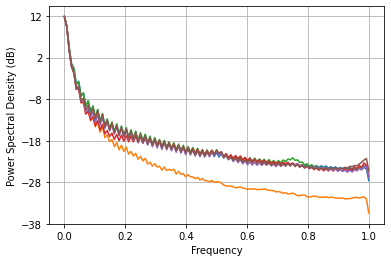

In [8]:
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import interp1d
xstand = np.linspace(0.0, 1., 1000)

xreal, yreal = plt.psd(fine[:, 0, ...].flatten().detach().cpu(), scale_by_freq=False, NFFT=2**8)
for exp in ["CNN", "nf", "5x5", "9x9", "13x13"]:
    x, y = plt.psd(results[exp][:, 0, ...].flatten().detach().cpu(), scale_by_freq=False, NFFT=2**8)
    assert np.allclose(y, yreal)
    print("Power spectrum density MAE from GT: ", exp, mean_absolute_error(10*np.log10(x), 10*np.log10(xreal)))
    print("Power spectrum density MAE from GT: ", exp, mean_absolute_error(x, xreal))

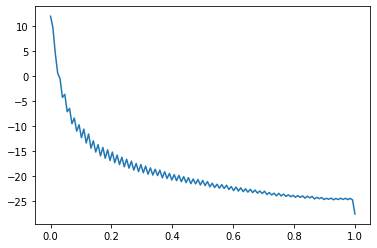

In [9]:
plt.plot(yreal, 10*np.log10(xreal))

In [10]:
corr = np.correlate(fine[:10, 0, ...].flatten().detach().cpu(), fine[:10, 0, ...].flatten().detach().cpu(), mode="full")

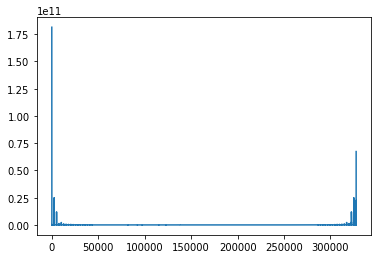

In [11]:
from scipy.fft import fft, ifft, fftshift

plt.plot(range(corr.shape[0]), np.abs(fft(corr)))

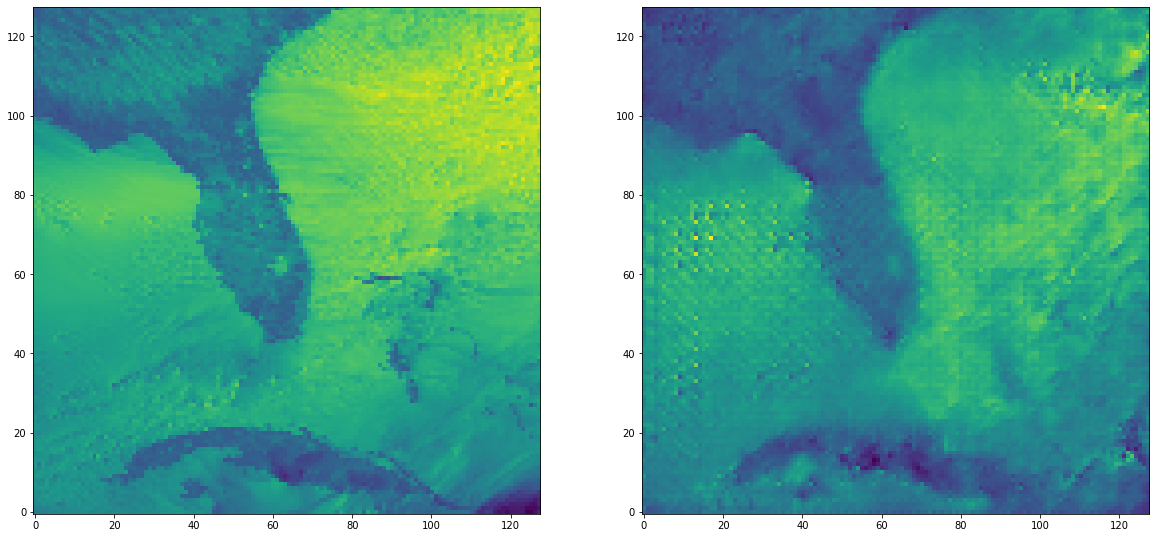

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
i = np.random.randint(1, fine.shape[0])
ax[0].imshow(fine[i, 0, ...].detach().cpu(), origin="lower")
ax[1].imshow(fake[i, 0, ...].detach().cpu(), origin="lower")

In [13]:
Ereal = fine[0, 0, ...]**2 + fine[0, 1, ...]**2

In [14]:
from scipy.fft import fft, ifft, fftshift


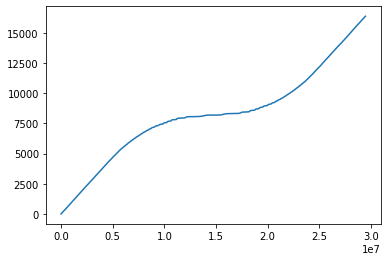

In [15]:
Ek = np.cumsum(np.abs(fftshift(fft(Ereal.cpu().numpy().flatten()))))
Ek.shape
plt.plot(Ek, range(Ek.shape[0]), )

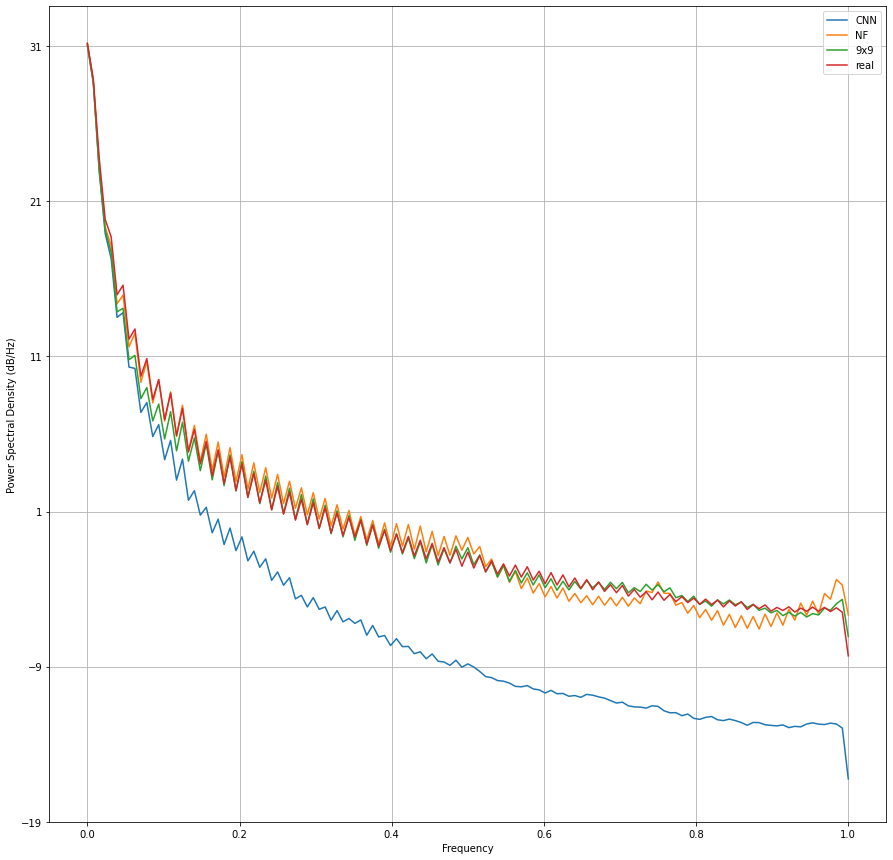

In [16]:
plt.figure(figsize=(15, 15))
x, y = plt.psd(results["CNN"][:, 0, ...].flatten().detach().cpu(), label="CNN")
x, y = plt.psd(results["nf"][:, 0, ...].flatten().detach().cpu(), label="NF")
# x, y = plt.psd(results["5x5"][:, 0, ...].flatten().detach().cpu(), label="5x5")
x, y = plt.psd(results["9x9"][:, 0, ...].flatten().detach().cpu(), label="9x9")
# x, y = plt.psd(results["13x13"][:, 0, ...].flatten().detach().cpu(), label="13x13")
x, y = plt.psd(fine[:, 0, ...].flatten().detach().cpu(), label="real")
plt.legend()

In [15]:
print(y)

[0.        0.0078125 0.015625  0.0234375 0.03125   0.0390625 0.046875
 0.0546875 0.0625    0.0703125 0.078125  0.0859375 0.09375   0.1015625
 0.109375  0.1171875 0.125     0.1328125 0.140625  0.1484375 0.15625
 0.1640625 0.171875  0.1796875 0.1875    0.1953125 0.203125  0.2109375
 0.21875   0.2265625 0.234375  0.2421875 0.25      0.2578125 0.265625
 0.2734375 0.28125   0.2890625 0.296875  0.3046875 0.3125    0.3203125
 0.328125  0.3359375 0.34375   0.3515625 0.359375  0.3671875 0.375
 0.3828125 0.390625  0.3984375 0.40625   0.4140625 0.421875  0.4296875
 0.4375    0.4453125 0.453125  0.4609375 0.46875   0.4765625 0.484375
 0.4921875 0.5       0.5078125 0.515625  0.5234375 0.53125   0.5390625
 0.546875  0.5546875 0.5625    0.5703125 0.578125  0.5859375 0.59375
 0.6015625 0.609375  0.6171875 0.625     0.6328125 0.640625  0.6484375
 0.65625   0.6640625 0.671875  0.6796875 0.6875    0.6953125 0.703125
 0.7109375 0.71875   0.7265625 0.734375  0.7421875 0.75      0.7578125
 0.765625  0.77343